In [6]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import pickle 
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
class ARGS():
    def __init__(self):
        self.mother_list = ['Llama-2-7b-hf','Qwen-1_8B','falcon-7b','internlm-7b','Yi-34B','Qwen-7B','Qwen-14B','deepseek-llm-7b-base','Yi-6B','Qwen-72B','mpt-7b','deepseek-llm-67b-base','Llama-2-13b-hf','Llama-2-70b-hf','falcon-40b','Mistral-7B-v0.1']
        # self.models = ['Llama-2-7b-hf','Qwen-1_8B','internlm-7b','Yi-34B','Qwen-7B','Qwen-14B','deepseek-llm-7b-base','Yi-6B','Qwen-72B','deepseek-llm-67b-base','Llama-2-13b-hf','Llama-2-70b-hf','falcon-40b','Mistral-7B-v0.1']
        # self.sub_list = ['Yi-34B','Qwen-72B','Qwen-14B','Llama-2-70b-hf','deepseek-llm-67b-base','Yi-6B']
        self.sub_list = ['Qwen-14B','Yi-6B','Mistral-7B-v0.1']
        self.indices = [self.mother_list.index(item) for item in self.sub_list]
        self.logits_data_dir = "D:/git-code/updated_code/ollama_fact/LLM-Uncertainty-Bench-main/LLM-Uncertainty-Bench-main/outputs_base"
        self.raw_data_dir = 'D:/git-code/updated_code/ollama_fact/LLM-Uncertainty-Bench-main/LLM-Uncertainty-Bench-main/data'
        self.data_names = ['mmlu_10k', 'cosmosqa_10k', 'hellaswag_10k', 'halu_dialogue', 'halu_summarization']
        self.tasks = {'mmlu_10k':'QA', 'cosmosqa_10k':'RC', 'hellaswag_10k':'CI', 'halu_dialogue':'DRS', 'halu_summarization':'DS'}
        self.alpha = 0.1
args = ARGS()
save = False

In [7]:
import matplotlib.pyplot as plt
def plot_accuracy(results, title, save):
    plt.figure()
    xs, ys, zs = results[:, 0], results[:, 1], results[:, 2]
    plt.plot(xs, ys, '-x')
    # zip joins x and y coordinates in pairs
    for x, y, z in zip(xs,ys, zs):
        label = "{:.0f}%".format(100 * z)
        plt.annotate(label, # this is the text
                     (x,y), # these are the coordinates to position the label
                     textcoords="offset points", # how to position the text
                     xytext=(0,-10), # distance from text to points (x,y)
                     ha='center') 
    plt.xlabel('uncertainty threshold')
    plt.ylabel('accuracy')
    if save:
        file = f'D:/git-code/updated_code/ollama_fact/figure/logists_token_model/{title}'
        plt.savefig(file + '.png')
        plt.savefig(file + '.pdf')
    plt.title(title)
    plt.show()
def uncertainty_acc_result(title, PUT_data, cal = False, plot_results = True, save = save):
    results = []
    for i in range(10):
        threshold = (i + 1) / 10
        p = PUT_data[:, -3]
        u = PUT_data[:, -2]
        t = PUT_data[:, -1]
        if cal: 
            # bucket algorithm
            quantiles = np.percentile(u, np.arange(10, 101, 10))
            new_u = np.zeros(len(u))
            for i, q in enumerate(quantiles):
                if i == 0:
                    new_u[u <= q] = i * 0.1
                else:
                    new_u[(u > quantiles[i - 1]) & (u <= q)] = i * 0.1
            mask = new_u <= threshold 
        else: mask = u <= threshold 
        acc = (p == t)[mask].sum() / max(1, sum(mask))
        perc_data = mask.mean()
        results.append([threshold, acc, perc_data])
    results = np.array(results)
    results = results[results[:,2]>0]
    if plot_results:
        plot_accuracy(results, title, save)
    return results

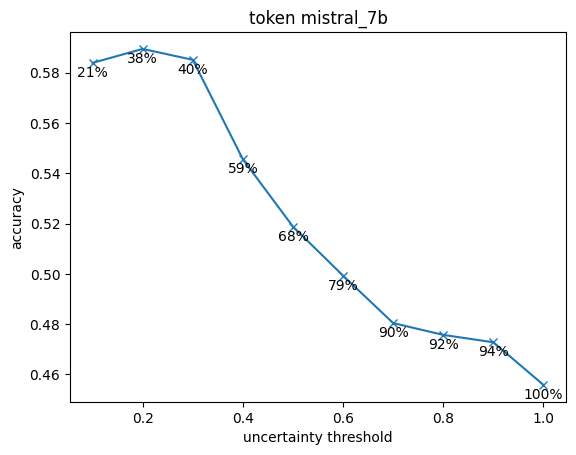

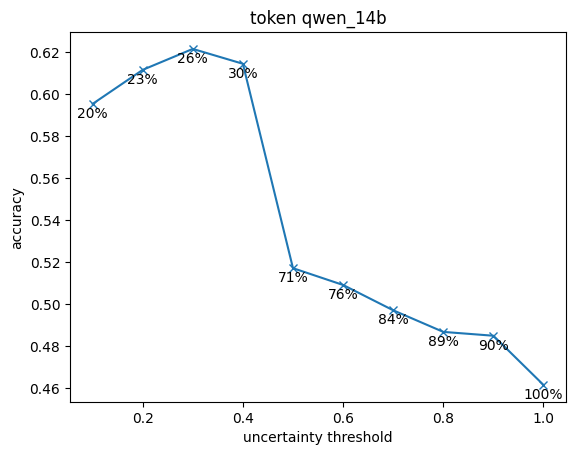

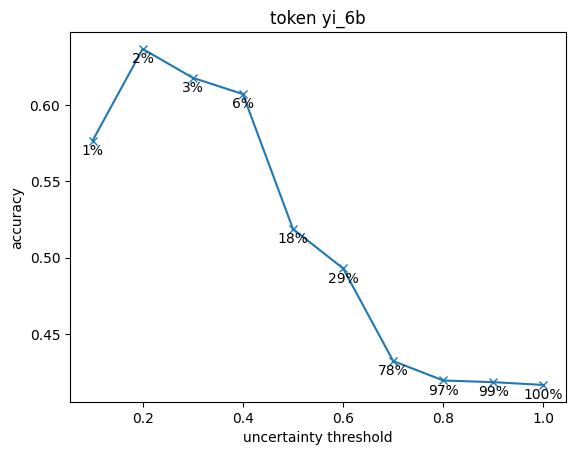

In [4]:
def jsonl_to_df(file):
    # 初始化一个空的列表来存储每行的字典
    file_path = f'D:/git-code/updated_code/ollama_fact/prompt/LLM_train_res/{file}.jsonl'
    data = []
    # 打开 JSONL 文件并逐行读取
    with open(file_path, 'r') as file:
        for line in file:
            try: 
                data.append(json.loads(line))
            except json.decoder.JSONDecodeError as e:
                print(line)
    df = pd.DataFrame(data)
    return df
file = 'MMLU_w'
df = jsonl_to_df(file)

models = df['model'].unique()
mapping = {'A': 0,'B': 1,'C': 2,'D': 3}
Token = {}
for model in models:
    df_model = df[df['model']==model]
    truth = np.array(df_model['answer'].map(mapping))
    token = np.array(df_model[['A', 'B', 'C', 'D', 'E', 'F']])
    model = model.split(':')[0]+'_'+model.split(':')[1]
    Token[model] = token / 100
    pred = np.argmax(token[:, :4], axis=1)
    uncertany = 1 - np.max(token[:, :4], axis=1) / 100
    put = np.column_stack((pred,uncertany,truth))
    uncertainty_acc_result(f'token {model}', put, cal = False, plot_results = True, save = True)

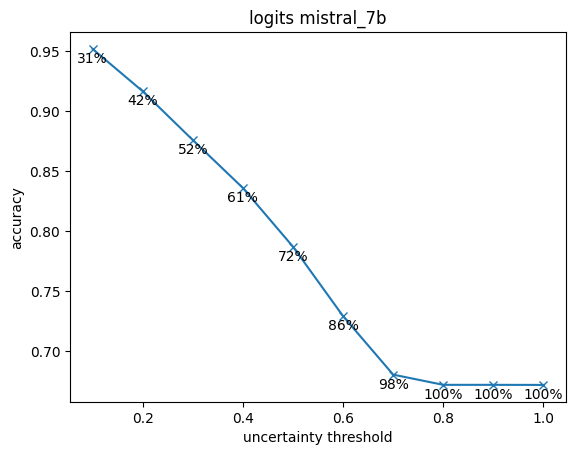

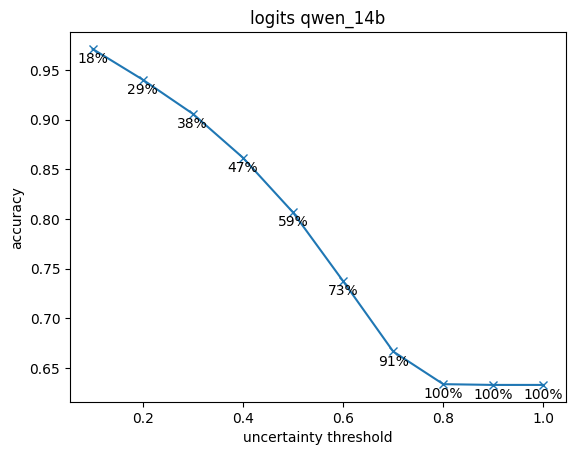

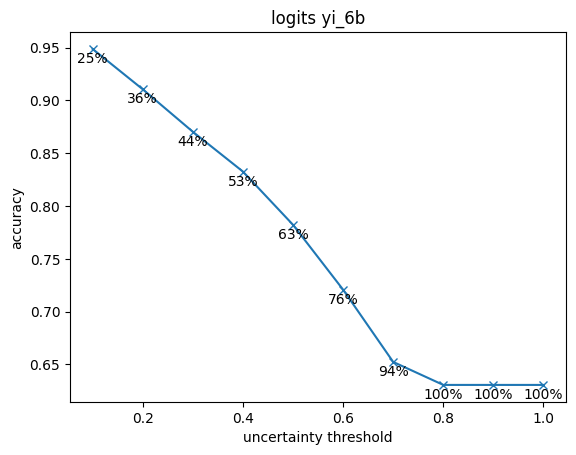

In [5]:
choice = {
      "A": "Wrong, Wrong",
      "B": "Wrong, Not wrong",
      "C": "Not wrong, Wrong",
      "D": "Not wrong, Not wrong",
      "E": "I don't know",
      "F": "None of the above"
    }
ls_id = []
ls_answer = []
labeled_data_path = 'D:/git-code/updated_code/ollama_fact/LLM-Uncertainty-Bench-main/LLM-Uncertainty-Bench-main/data/'
MMLU_file = labeled_data_path + 'mmlu_10k.json'
with open(MMLU_file, 'r', encoding='utf-8') as data:
    ls_total_data = json.load(data)
for i in range(len(ls_total_data)):
    if ls_total_data[i]['choices'] != choice: 
        ls_id.append(i)
        ls_answer.append(mapping[ls_total_data[i]['answer']])
logits_truth = np.array(ls_answer)
def softmax_2d(array):
    max_per_row = np.max(array, axis=1, keepdims=True)
    exp_array = np.exp(array - max_per_row)
    sum_per_row = np.sum(exp_array, axis=1, keepdims=True)
    softmax_result = exp_array / sum_per_row
    return softmax_result

Logits = {}
models = [model.split(':')[0]+'_'+model.split(':')[1] for model in models]
model_map = dict(zip(args.sub_list, models))
for model in args.sub_list:
    logits_file = os.path.join(args.logits_data_dir, model+"_mmlu_10k_base_icl1.pkl")
    with open(logits_file, 'rb') as f:
        logits_data = pickle.load(f)
        logits_w_data = [logits_data[i] for i in ls_id]
    model = model_map[model]
    Logits[model] = softmax_2d(np.array([item['logits_options'] for _, item in enumerate(logits_w_data)]))
    logits_pred = np.argmax(Logits[model], axis=1)
    logits_uncertainty = 1 - np.max(Logits[model][:, :4], axis=1)
    logits_put = np.column_stack((logits_pred,logits_uncertainty,logits_truth))
    uncertainty_acc_result(f'logits {model}', logits_put, cal = False, plot_results = True, save = True)

In [14]:
def llm_ensemble(Logits):
    random_state = 78
    W = np.column_stack([np.argmax(train_test_split(value[:, :4], test_size=0.2, random_state=random_state)[1], axis=1) for value in Logits.values()])
    W_A = (W == 0).astype(int)
    W_B = (W == 1).astype(int)
    W_C = (W == 2).astype(int)
    W_D = (W == 3).astype(int)
    updata_v = np.ones(len(Logits.keys()))
    iter = 100
    eps = 1e-5
    v = np.zeros(len(Logits.keys()))
    i = 0
    while np.linalg.norm(updata_v - v) > eps and i < iter:
        v = updata_v
        updata_y = np.argmax(np.column_stack((W_A@v, W_B@v, W_C@v, W_D@v)), axis=1)
        updata_v = np.array([(W[:,i] == updata_y).astype(int).mean() for i in range(W.shape[1])])
    return updata_y
def ml_comparison(S, models, truth, para):
    random_state = 78
    X = np.hstack([S[model].reshape(-1,S[model].shape[-1]) for model in models])
    X_train, X_test, y_train, y_test = train_test_split(X, truth, test_size=0.2, random_state=random_state)
    def evaluate_model(model, X_train, y_train, X_test, y_test):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1_macro = f1_score(y_test, y_pred, average='macro')  # 宏平均F1分数
        return (f1_macro, accuracy, y_pred.tolist(), y_test.tolist())
    log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
    svm_clf = SVC(decision_function_shape='ovr',probability=True)
    xgb_clf = xgb.XGBClassifier(n_estimators=100, eval_metric='mlogloss', random_state=random_state, device = "cuda")
    dc_ml = {
            'Logistic Regression': evaluate_model(log_reg, X_train, y_train, X_test, y_test),
            'SVM': evaluate_model(svm_clf, X_train, y_train, X_test, y_test),
            'XGBoost': evaluate_model(xgb_clf, X_train, y_train, X_test, y_test)
            }
    S_avg = np.mean([S[model].reshape(-1,S[model].shape[-1])[:,:4] for model in models], axis=0)
    train_S_avg, test_S_avg = train_test_split(S_avg, test_size=0.2, random_state=random_state)
    baseline_pred = np.argmax(test_S_avg, axis=1)
    dc_ml['baseline'] = (f1_score(y_test, baseline_pred, average='macro'), accuracy_score(y_test, baseline_pred), baseline_pred)
    # llm_ensemble_pred = llm_ensemble(S)
    # dc_ml['llm_ensemble'] = (f1_score(y_test, llm_ensemble_pred, average='macro'), accuracy_score(y_test, llm_ensemble_pred), llm_ensemble_pred) 
    result = {}
    for method in dc_ml.keys():
        P = dc_ml[method][2]
        U = 1 - test_S_avg[np.arange(len(P)), P]
        PUT_data = np.column_stack((P, U, y_test))
        result[method] = uncertainty_acc_result(method+f' {para}', PUT_data, cal = False, plot_results=False, save=False)
    def plot_accuracy_multiple(models_results, title='Model Accuracy Comparison', save=save):
        """
        models_results 是一个列表，包含多个 (model_name, results) 的元组。
        model_name 是字符串，results 是对应模型的 10行3列 二维数组。
        """
        plt.figure(figsize=(10, 6))  # 设置图像大小
        linestyles = ['-', '--', '-.', ':']  # 不同的线型
        markers = ['o', 's', '^', 'v', 'x']  # 不同的标记
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']  # 可选的颜色
        for i, model in enumerate(result):
            xs, ys, zs = models_results[model][:, 0], models_results[model][:, 1], models_results[model][:, 2]
            plt.plot(xs, ys, label=model, 
                    linestyle=linestyles[i % len(linestyles)],  # 循环使用线型
                    marker=markers[i % len(markers)],  # 循环使用标记
                    color=colors[i % len(colors)],  # 循环使用颜色
                    markersize=6,  # 标记大小
                    linewidth=2)  # 线宽
            for x, y, z in zip(xs,ys, zs):
                label = "{:.0f}%".format(100 * z)
                plt.annotate(label, # this is the text
                     (x,y), # these are the coordinates to position the label
                     textcoords="offset points", # how to position the text
                     xytext=(0,-10), # distance from text to points (x,y)
                     ha='center') 
        plt.xlabel('uncertainty threshold')
        plt.ylabel('accuracy')
        plt.legend()  # 显示图例，区分不同模型
        plt.title(title)
        if save:
            plt.savefig(f'D:/git-code/updated_code/ollama_fact/figure/logits_vs_token/{title}.png')
            plt.savefig(f'D:/git-code/updated_code/ollama_fact/figure/logits_vs_token/{title}.pdf')
        plt.show()
    plot_accuracy_multiple(result,title=f'{para}')
    print('function over')
    return result

d:\anaconda\envs\pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


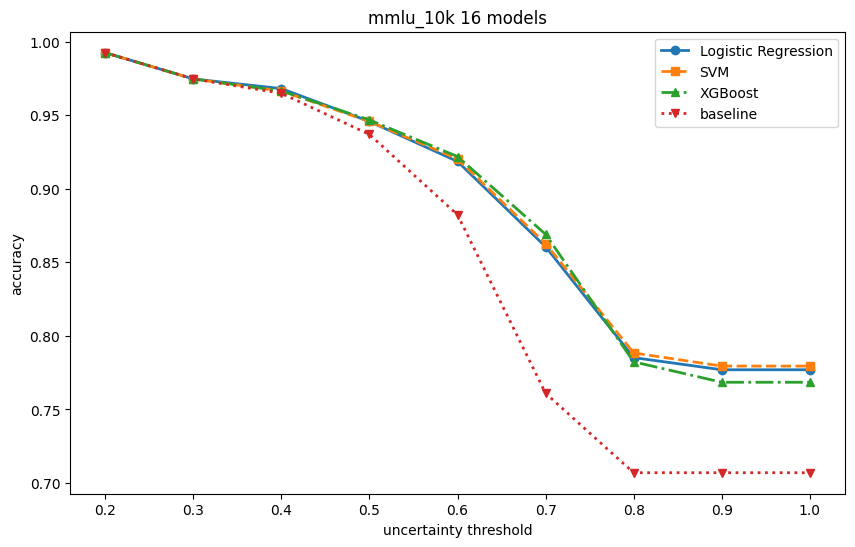

d:\anaconda\envs\pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


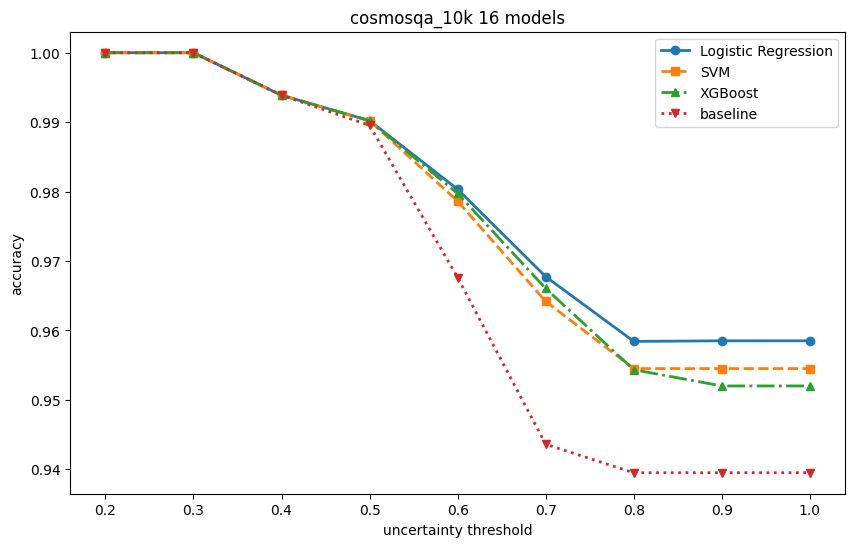

d:\anaconda\envs\pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


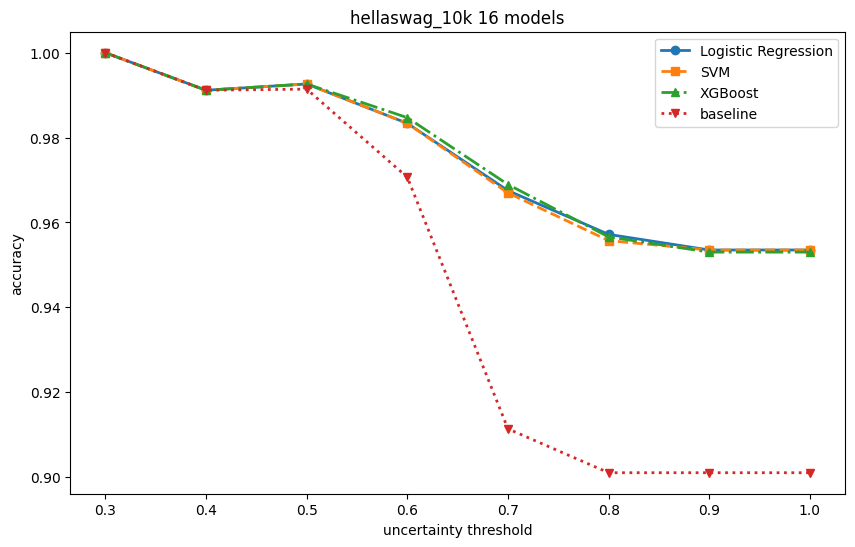

d:\anaconda\envs\pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


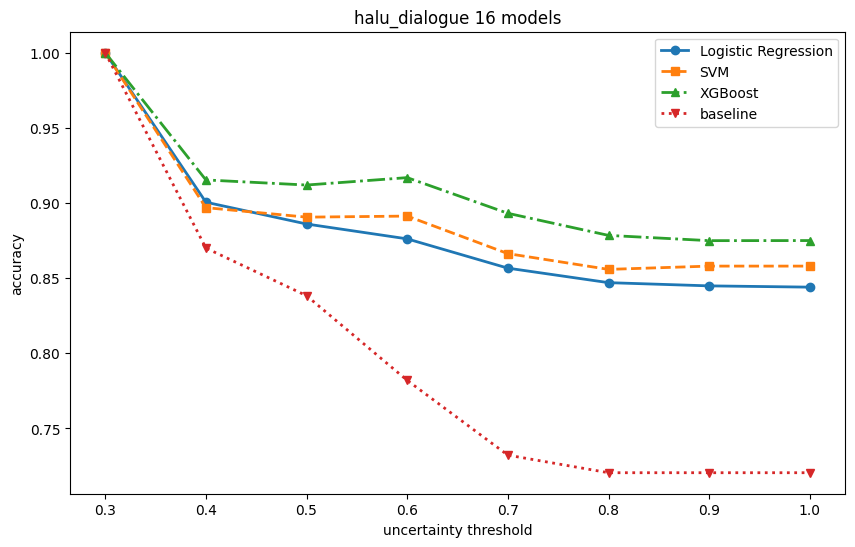

d:\anaconda\envs\pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


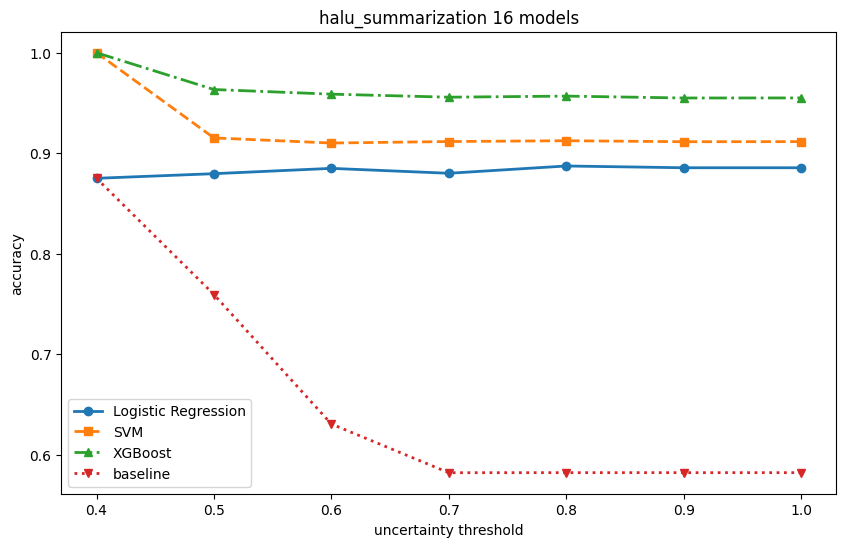

In [ ]:
# 不同数据集
for data_name in args.data_names:
    ls_answer = []
    labeled_data_path = 'D:/git-code/updated_code/ollama_fact/LLM-Uncertainty-Bench-main/LLM-Uncertainty-Bench-main/data/'
    file = labeled_data_path + data_name + '.json'
    with open(file, 'r', encoding='utf-8') as data:
        ls_total_data = json.load(data)
    truth = np.array([mapping[i['answer']] for i in ls_total_data])
    Logits = {}
    for model in args.mother_list:   
        logits_file = os.path.join(args.logits_data_dir, model+"_"+data_name+"_base_icl1.pkl")
        with open(logits_file, 'rb') as f:
            logits_data = pickle.load(f)
        Logits[model] = softmax_2d(np.array([item['logits_options'] for _, item in enumerate(logits_data)]))
        # logits_pred = np.argmax(Logits[model], axis=1)
        # logits_uncertainty = 1 - np.max(Logits[model][:, :4], axis=1)
        # logits_put = np.column_stack((logits_pred,logits_uncertainty,logits_truth))
        # uncertainty_acc_result(f'logits {model}', logits_put, cal = False, plot_results = True, save = True)
    ml_comparison(S=Logits, models=args.mother_list, truth=truth, para=f'{data_name} 16 models')
        

d:\anaconda\envs\pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


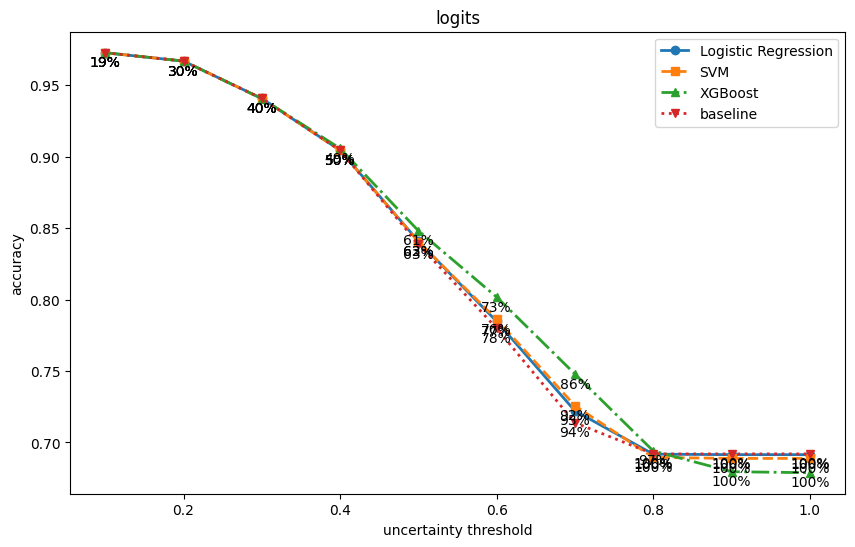

function over


{'Logistic Regression': array([[0.1       , 0.97275204, 0.19325961],
        [0.2       , 0.96689895, 0.30226435],
        [0.3       , 0.94071146, 0.39968404],
        [0.4       , 0.9044586 , 0.49605055],
        [0.5       , 0.84077506, 0.62506582],
        [0.6       , 0.784689  , 0.77040548],
        [0.7       , 0.7220339 , 0.93206951],
        [0.8       , 0.69178082, 0.99947341],
        [0.9       , 0.69141654, 1.        ],
        [1.        , 0.69141654, 1.        ]]),
 'SVM': array([[0.1       , 0.97275204, 0.19325961],
        [0.2       , 0.96689895, 0.30226435],
        [0.3       , 0.94071146, 0.39968404],
        [0.4       , 0.90435707, 0.49552396],
        [0.5       , 0.84050633, 0.62401264],
        [0.6       , 0.78605935, 0.76303318],
        [0.7       , 0.72565865, 0.91943128],
        [0.8       , 0.68950975, 0.99894681],
        [0.9       , 0.68878357, 1.        ],
        [1.        , 0.68878357, 1.        ]]),
 'XGBoost': array([[0.1       , 0.97275204, 0.

In [27]:
result_l = ml_comparison(S=Logits, models=models, truth=truth, para='logits')
result_l

d:\anaconda\envs\pytorch\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


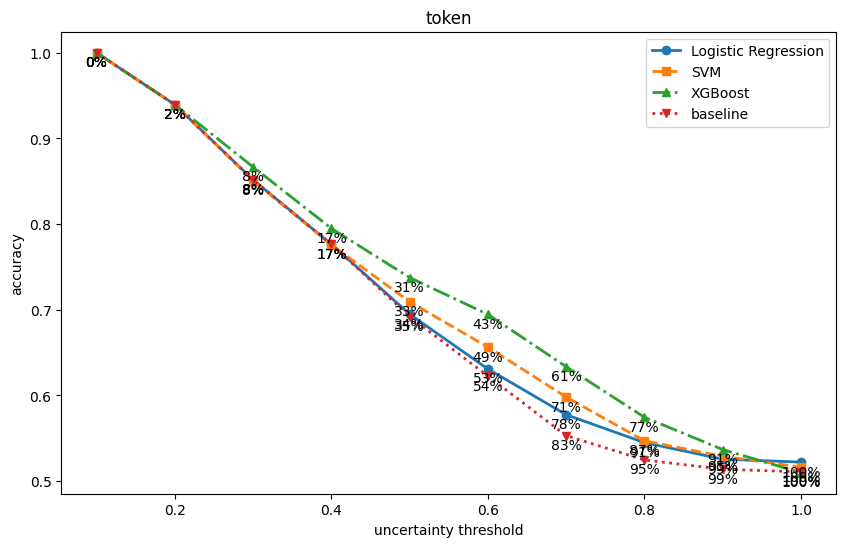

function over


{'Logistic Regression': array([[0.1       , 1.        , 0.00421274],
        [0.2       , 0.93939394, 0.01737757],
        [0.3       , 0.8516129 , 0.08162191],
        [0.4       , 0.77643505, 0.17430226],
        [0.5       , 0.69478528, 0.3433386 ],
        [0.6       , 0.63084577, 0.52922591],
        [0.7       , 0.57744565, 0.77514481],
        [0.8       , 0.54487551, 0.90942601],
        [0.9       , 0.52555911, 0.98894155],
        [1.        , 0.52212856, 0.99947341]]),
 'SVM': array([[0.1       , 1.        , 0.00421274],
        [0.2       , 0.93939394, 0.01737757],
        [0.3       , 0.85064935, 0.08109531],
        [0.4       , 0.77575758, 0.17377567],
        [0.5       , 0.7093207 , 0.33333333],
        [0.6       , 0.65631692, 0.49183781],
        [0.7       , 0.5980755 , 0.71142707],
        [0.8       , 0.54698795, 0.87414429],
        [0.9       , 0.52895753, 0.95471301],
        [1.        , 0.51633298, 0.99947341]]),
 'XGBoost': array([[0.1       , 1.        , 0.

In [15]:
result_t = ml_comparison(S=Token, models=models, truth=truth, para='token')
result_t

In [ ]:
for key in result_t.keys():
    print(key)
    

In [23]:
pd.DataFrame(np.round(result_t['SVM'].T, 4),index=['uncertainty','accuracy','data_percentage'])

,0,1,2,3,4,5,6,7,8,9
uncertainty,0.1000,0.2000,0.3000,0.4000,0.5000,0.6000,0.7000,0.8000,0.9000,1.0000
accuracy,1.0000,0.9394,0.8506,0.7758,0.7093,0.6563,0.5981,0.5470,0.5290,0.5163
data_percentage,0.0042,0.0174,0.0811,0.1738,0.3333,0.4918,0.7114,0.8741,0.9547,0.9995


In [30]:
# 创建一个空的列表用于存储结果
frames = []

# 对每个方法进行操作
for method in result_l.keys():
    df = pd.DataFrame(np.round(result_l[method].T, 4), index=['uncertainty', 'accuracy', 'data_percentage'])
    df.index = pd.MultiIndex.from_product([[method], df.index])  # 添加母列，设置多级索引
    frames.append(df)

# 将所有 DataFrame 合并为一个
final_df = pd.concat(frames)

final_df

0       1       2       3       4  \
Logistic Regression uncertainty      0.1000  0.2000  0.3000  0.4000  0.5000   
                    accuracy         0.9728  0.9669  0.9407  0.9045  0.8408   
                    data_percentage  0.1933  0.3023  0.3997  0.4961  0.6251   
SVM                 uncertainty      0.1000  0.2000  0.3000  0.4000  0.5000   
                    accuracy         0.9728  0.9669  0.9407  0.9044  0.8405   
                    data_percentage  0.1933  0.3023  0.3997  0.4955  0.6240   
XGBoost             uncertainty      0.1000  0.2000  0.3000  0.4000  0.5000   
                    accuracy         0.9728  0.9669  0.9406  0.9058  0.8481   
                    data_percentage  0.1933  0.3023  0.3992  0.4918  0.6103   
baseline            uncertainty      0.1000  0.2000  0.3000  0.4000  0.5000   
                    accuracy         0.9728  0.9669  0.9407  0.9045  0.8388   
                    data_percentage  0.1933  0.3023  0.3997  0.4961  0.6272   

                                          5       6       7       8       9  
Logistic Regression uncertainty      0.6000  0.7000  0.8000  0.9000  1.0000  
                    accuracy         0.7847  0.7220  0.6918  0.6914  0.6914  
                    data_percentage  0.7704  0.9321  0.9995  1.0000  1.0000  
SVM                 uncertainty      0.6000  0.7000  0.8000  0.9000  1.0000  
                    accuracy         0.7861  0.7257  0.6895  0.6888  0.6888  
                    data_percentage  0.7630  0.9194  0.9989  1.0000  1.0000  
XGBoost             uncertainty      0.6000  0.7000  0.8000  0.9000  1.0000  
                    accuracy         0.8017  0.7479  0.6940  0.6795  0.6788  
                    data_percentage  0.7304  0.8583  0.9689  0.9989  1.0000  
baseline            uncertainty      0.6000  0.7000  0.8000  0.9000  1.0000  
                    accuracy         0.7798  0.7137  0.6919  0.6919  0.6919  
                    data_percentage  0.7773  0.9437  1.0000  1.0000  1.0000